# Jupiter Multi-Hop Detection & Analysis

## Objective
Detect and analyze Jupiter routing through your pAMM by identifying multi-hop transactions vs single-hop direct swaps.

## Key Insight
Your `trades` column already contains the full routing path! We use hop count (length of trades array) to distinguish:
- **Multi-hop**: route through 2+ DEXes (likely Jupiter → Raydium → Your pAMM, etc.)
- **Single-hop**: direct swap through one AMM
- **Direct**: no routing detected

This is equivalent to detecting Jupiter without needing raw program IDs.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime
import json

%matplotlib inline
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

print("Libraries imported successfully.")

Libraries imported successfully.


## Step 1: Load Cleaned Data

In [5]:
# Load the cleaned data from 01_data_cleaning
data_path = '01_data_cleaning/outputs/pamm_clean_final.parquet'
df = pd.read_parquet(data_path)

print(f"Data loaded: {len(df):,} rows, {len(df.columns)} columns")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nData range: {df['datetime'].min()} to {df['datetime'].max()}")

Data loaded: 5,506,090 rows, 18 columns

Columns: ['slot', 'time', 'validator', 'tx_idx', 'sig', 'signer', 'kind', 'amm_oracle', 'account_updates', 'trades', 'us_since_first_shred', 'amm_trade', 'account_trade', 'is_pool_trade', 'bytes_changed_trade', 'timing_missing', 'ms_time', 'datetime']

Data range: 1970-01-30 10:19:36.344000+00:00 to 1970-01-30 21:21:51.678000+00:00


## Step 2: Add Jupiter Detection Columns

In [7]:
# ────────────────────────────────────────────────────────────
# Function 1: Count hops (multi-leg trades)
# ────────────────────────────────────────────────────────────
def count_hops(trades_array):
    """
    Count the number of hops in a trade route.
    
    Args:
        trades_array: numpy array or list of trade dicts, or None/NaN
    
    Returns:
        int: number of hops (legs in the route)
            0 = no trades
            1 = single-hop (direct swap)
            2+ = multi-hop (routed through aggregator)
    """
    if trades_array is None or (isinstance(trades_array, float) and np.isnan(trades_array)):
        return 0
    
    if isinstance(trades_array, np.ndarray):
        return len(trades_array)
    
    if isinstance(trades_array, list):
        return len(trades_array)
    
    return 0

# ────────────────────────────────────────────────────────────
# Function 2: Extract route details (for reference)
# ────────────────────────────────────────────────────────────
def get_route_key(trades_array):
    """
    Get a string representation of the route for grouping.
    Format: AMM1->AMM2->AMM3
    """
    hops = count_hops(trades_array)
    if hops == 0:
        return 'no_route'
    
    if isinstance(trades_array, np.ndarray):
        trades_list = trades_array.tolist()
    else:
        trades_list = trades_array if isinstance(trades_array, list) else []
    
    amms = []
    for trade in trades_list:
        if isinstance(trade, dict) and 'amm' in trade:
            # Shorten AMM address to first 4 chars for readability
            amm_short = trade['amm'][:4] if len(trade['amm']) >= 4 else trade['amm']
            amms.append(amm_short)
    
    if not amms:
        return f'hops_{hops}'
    
    return '->'.join(amms)

print("\nAdding hop detection columns...")

# 1. Count hops per transaction
df['hop_count'] = df['trades'].apply(count_hops)

# 2. Route representation (useful for detailed analysis)
df['route_key'] = df['trades'].apply(get_route_key)

# 3. Simple tags
df['has_routing'] = df['hop_count'] > 0  # Any multi-leg routing
df['is_multihop'] = df['hop_count'] > 1  # Multi-hop (aggregator-like)
df['is_singlehop'] = df['hop_count'] == 1  # Direct single swap
df['is_direct'] = df['hop_count'] == 0  # No routing detected

print(f"\n✓ Columns added:")
print(f"  - hop_count: number of legs in route")
print(f"  - is_multihop: Boolean (True if 2+ hops)")
print(f"  - is_singlehop: Boolean (True if 1 hop)")
print(f"  - is_direct: Boolean (True if 0 hops)")
print(f"  - route_key: route identifier for grouping")

# Preview
print("\nSample rows with hop counts:")
sample = df[['sig', 'amm_trade', 'hop_count', 'is_multihop', 'route_key']].head(10)
print(sample.to_string(index=False))


Adding hop detection columns...

✓ Columns added:
  - hop_count: number of legs in route
  - is_multihop: Boolean (True if 2+ hops)
  - is_singlehop: Boolean (True if 1 hop)
  - is_direct: Boolean (True if 0 hops)
  - route_key: route identifier for grouping

Sample rows with hop counts:
                                                                                     sig amm_trade  hop_count  is_multihop        route_key
2GRgayeGramRzDCpucAhmmShoZir4Nw1Fdj9vQW5Y5aVFNsCpyxnSe1VDFvUfFwDWVyqbR9ZaXhb8xQN8ig78J5h  HumidiFi          0        False         no_route
 mPMR4aZTchp6NqjmCeao9T62t7scwFUhk66qLhB3U22dh8n25VJJZrFymDgTS28vrjibpd8SZbjTbKTKF6jbz7J  HumidiFi          0        False         no_route
2YbkBXYWU6eLsZD1FK6Whez6PBZGPfUYh7vLrqCJFxoguhuP7JxvXzW2Uuw45sqKLRFY6scVdxJXd8JkugeMKgGp  HumidiFi          0        False         no_route
45Q9XrWZhpWML6dh4h3SrWziLLweYUc2kmY9pZHo6RHSRxfqmeTyrUvfQfQmKV9Xg4P3fRhS9T9SberUA3xANKdg  HumidiFi          0        False         no_route
5HEut72ZbB

## Step 3: Hop Distribution Analysis

In [11]:
# ────────────────────────────────────────────────────────────
# Basic hop count distribution
# ────────────────────────────────────────────────────────────
print("\n" + "="*70)
print("HOP COUNT DISTRIBUTION")
print("="*70)

hop_dist = df['hop_count'].value_counts().sort_index()
hop_dist_pct = (hop_dist / len(df) * 100).round(2)

hop_summary = pd.DataFrame({
    'Hop Count': hop_dist.index,
    'Transaction Count': hop_dist.values,
    'Percentage': hop_dist_pct.values
}).reset_index(drop=True)

print(hop_summary.to_string(index=False))

# Key metrics
multihop_count = df['is_multihop'].sum()
multihop_pct = multihop_count / len(df) * 100
singlehop_count = df['is_singlehop'].sum()
singlehop_pct = singlehop_count / len(df) * 100
direct_count = df['is_direct'].sum()
direct_pct = direct_count / len(df) * 100

print(f"\n" + "-"*70)
print(f"BUCKETED SUMMARY:")
print(f"-"*70)
print(f"Multi-Hop (2+ legs):   {multihop_count:>12,}  ({multihop_pct:>6.2f}%)  ← Jupiter-like routing")
print(f"Single-Hop (1 leg):    {singlehop_count:>12,}  ({singlehop_pct:>6.2f}%)  ← Direct swaps")
print(f"Direct (0 hops):       {direct_count:>12,}  ({direct_pct:>6.2f}%)  ← No routing")
print(f"TOTAL:                 {len(df):>12,}  (100.00%)")
print(f"-"*70)


HOP COUNT DISTRIBUTION
 Hop Count  Transaction Count  Percentage
         0            4822262       87.58
         1             131578        2.39
         2             245422        4.46
         3             207526        3.77
         4              78722        1.43
         5              18276        0.33
         6               2304        0.04

----------------------------------------------------------------------
BUCKETED SUMMARY:
----------------------------------------------------------------------
Multi-Hop (2+ legs):        552,250  ( 10.03%)  ← Jupiter-like routing
Single-Hop (1 leg):         131,578  (  2.39%)  ← Direct swaps
Direct (0 hops):          4,822,262  ( 87.58%)  ← No routing
TOTAL:                    5,506,090  (100.00%)
----------------------------------------------------------------------


## Step 4: Transaction-Level Metrics (Volume & PnL if available)

In [12]:
# ────────────────────────────────────────────────────────────
# Check what numerical columns are available
# ────────────────────────────────────────────────────────────
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print(f"Available numeric columns: {numeric_cols}")

# Create aggregation by routing type
print("\n" + "="*70)
print("METRICS BY ROUTING TYPE")
print("="*70)

agg_dict = {
    'sig': 'count',  # Transaction count
    'slot': 'min',   # Time range
}

routing_groups = df.groupby('is_multihop').agg(agg_dict).rename(columns={'sig': 'tx_count', 'slot': 'earliest_slot'})
routing_groups.index = ['Non-Multi-Hop', 'Multi-Hop']

print(routing_groups)

# Breakdown by hop count
print("\n" + "-"*70)
print("DETAILED BREAKDOWN BY HOP COUNT:")
print("-"*70)

hop_breakdown = df.groupby('hop_count').agg({
    'sig': 'count',
    'kind': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'N/A',  # Most common event type
    'amm_trade': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'N/A',  # Most common AMM
}).rename(columns={'sig': 'tx_count', 'kind': 'dominant_event', 'amm_trade': 'dominant_amm'})

print(hop_breakdown)

Available numeric columns: ['slot', 'time', 'tx_idx', 'us_since_first_shred', 'bytes_changed_trade', 'ms_time', 'hop_count']

METRICS BY ROUTING TYPE
               tx_count  earliest_slot
Non-Multi-Hop   4953840      391876700
Multi-Hop        552250      391876700

----------------------------------------------------------------------
DETAILED BREAKDOWN BY HOP COUNT:
----------------------------------------------------------------------
           tx_count dominant_event dominant_amm
hop_count                                      
0           4822262         ORACLE     HumidiFi
1            131578          TRADE     HumidiFi
2            245422          TRADE     HumidiFi
3            207526          TRADE     HumidiFi
4             78722          TRADE     HumidiFi
5             18276          TRADE       GoonFi
6              2304          TRADE       ZeroFi


## Step 5: Top Multi-Hop Routes

In [14]:
# ────────────────────────────────────────────────────────────
# Identify the most common multi-hop routes
# ────────────────────────────────────────────────────────────
print("\n" + "="*70)
print("TOP 20 MOST COMMON MULTI-HOP ROUTES")
print("="*70)

multihop_df = df[df['is_multihop']].copy()

if len(multihop_df) > 0:
    top_routes = multihop_df['route_key'].value_counts().head(20)
    for idx, (route, count) in enumerate(top_routes.items(), 1):
        pct = count / len(multihop_df) * 100
        print(f"{idx:2d}. {route:40s}  {count:>8,} txs  ({pct:>6.2f}%)")
    
    print(f"\nTotal unique multi-hop routes: {multihop_df['route_key'].nunique()}")
else:
    print("No multi-hop transactions found.")

# Also show top single-hop routes for comparison
print("\n" + "-"*70)
print("TOP 10 MOST COMMON SINGLE-HOP ROUTES (for comparison)")
print("-"*70)

singlehop_df = df[df['is_singlehop']].copy()

if len(singlehop_df) > 0:
    top_single = singlehop_df['route_key'].value_counts().head(10)
    for idx, (route, count) in enumerate(top_single.items(), 1):
        pct = count / len(singlehop_df) * 100
        print(f"{idx:2d}. {route:40s}  {count:>8,} txs  ({pct:>6.2f}%)")
    
    print(f"\nTotal unique single-hop routes: {singlehop_df['route_key'].nunique()}")
else:
    print("No single-hop transactions found.")


TOP 20 MOST COMMON MULTI-HOP ROUTES
 1. Tess->9H6t                                  19,472 txs  (  3.53%)
 2. 9H6t->Tess                                  13,889 txs  (  2.51%)
 3. 9H6t->BiSo                                   7,900 txs  (  1.43%)
 4. 9H6t->LBUZ                                   7,132 txs  (  1.29%)
 5. LBUZ->9H6t                                   6,372 txs  (  1.15%)
 6. 9H6t->whir                                   6,372 txs  (  1.15%)
 7. whir->9H6t                                   6,236 txs  (  1.13%)
 8. CAMM->9H6t                                   5,028 txs  (  0.91%)
 9. HpNf->9H6t                                   4,948 txs  (  0.90%)
10. goon->SV2E                                   4,882 txs  (  0.88%)
11. 9H6t->CAMM                                   4,842 txs  (  0.88%)
12. 9H6t->HpNf                                   4,446 txs  (  0.81%)
13. 9H6t->pAMM                                   3,710 txs  (  0.67%)
14. SV2E->goon                                   3,52

## Step 6: Time-Series Analysis

In [16]:
# ────────────────────────────────────────────────────────────
# Time-series: Multi-hop vs Direct over time
# ────────────────────────────────────────────────────────────

# Group by hour
df['hour'] = df['datetime'].dt.floor('h')

hourly_routing = df.groupby('hour').agg({
    'is_multihop': 'sum',
    'is_singlehop': 'sum',
    'is_direct': 'sum',
    'sig': 'count'
}).rename(columns={'sig': 'total_tx'})

# Calculate percentages
hourly_routing['multihop_pct'] = hourly_routing['is_multihop'] / hourly_routing['total_tx'] * 100
hourly_routing['singlehop_pct'] = hourly_routing['is_singlehop'] / hourly_routing['total_tx'] * 100

print("\nHourly routing breakdown (first 10 hours):")
print(hourly_routing[['is_multihop', 'is_singlehop', 'is_direct', 'multihop_pct', 'singlehop_pct']].head(10))


Hourly routing breakdown (first 10 hours):
                           is_multihop  is_singlehop  is_direct  multihop_pct  \
hour                                                                            
1970-01-30 10:00:00+00:00        30084          7525     251257     10.414517   
1970-01-30 11:00:00+00:00        59040         12795     537536      9.688679   
1970-01-30 12:00:00+00:00        42821         11986     359966     10.323960   
1970-01-30 13:00:00+00:00        40667         13158     317401     10.954782   
1970-01-30 14:00:00+00:00        42699         13249     333498     10.964036   
1970-01-30 15:00:00+00:00        55519         13488     400377     11.828055   
1970-01-30 16:00:00+00:00        63333         12090     607824      9.269415   
1970-01-30 17:00:00+00:00        53256         10303     539658      8.828664   
1970-01-30 18:00:00+00:00        52804         11032     460491     10.070815   
1970-01-30 19:00:00+00:00        46294         10694     395303  

## Step 7: Visualizations

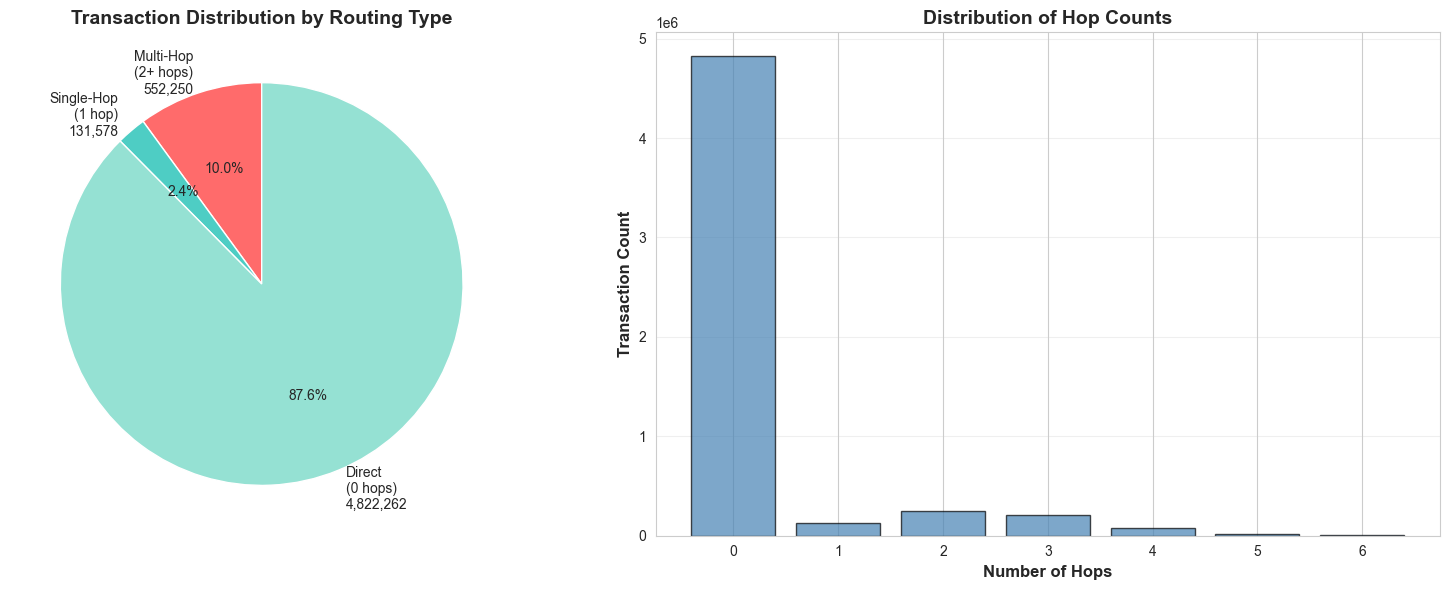

✓ Saved: 02_jupiter_routing_distribution.png


In [19]:
# ────────────────────────────────────────────────────────────
# Figure 1: Hop Count Distribution (Pie Chart)
# ────────────────────────────────────────────────────────────

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Pie chart
routing_counts = [
    multihop_count,
    singlehop_count,
    direct_count
]
routing_labels = [
    f'Multi-Hop\n(2+ hops)\n{multihop_count:,}',
    f'Single-Hop\n(1 hop)\n{singlehop_count:,}',
    f'Direct\n(0 hops)\n{direct_count:,}'
]
colors = ['#FF6B6B', '#4ECDC4', '#95E1D3']

axes[0].pie(routing_counts, labels=routing_labels, colors=colors, autopct='%1.1f%%', startangle=90)
axes[0].set_title('Transaction Distribution by Routing Type', fontsize=14, fontweight='bold')

# Bar chart of hop counts
hop_counts_all = df['hop_count'].value_counts().sort_index()
axes[1].bar(hop_counts_all.index, hop_counts_all.values, color='steelblue', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Number of Hops', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Transaction Count', fontsize=12, fontweight='bold')
axes[1].set_title('Distribution of Hop Counts', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('02_jupiter_routing_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: 02_jupiter_routing_distribution.png")

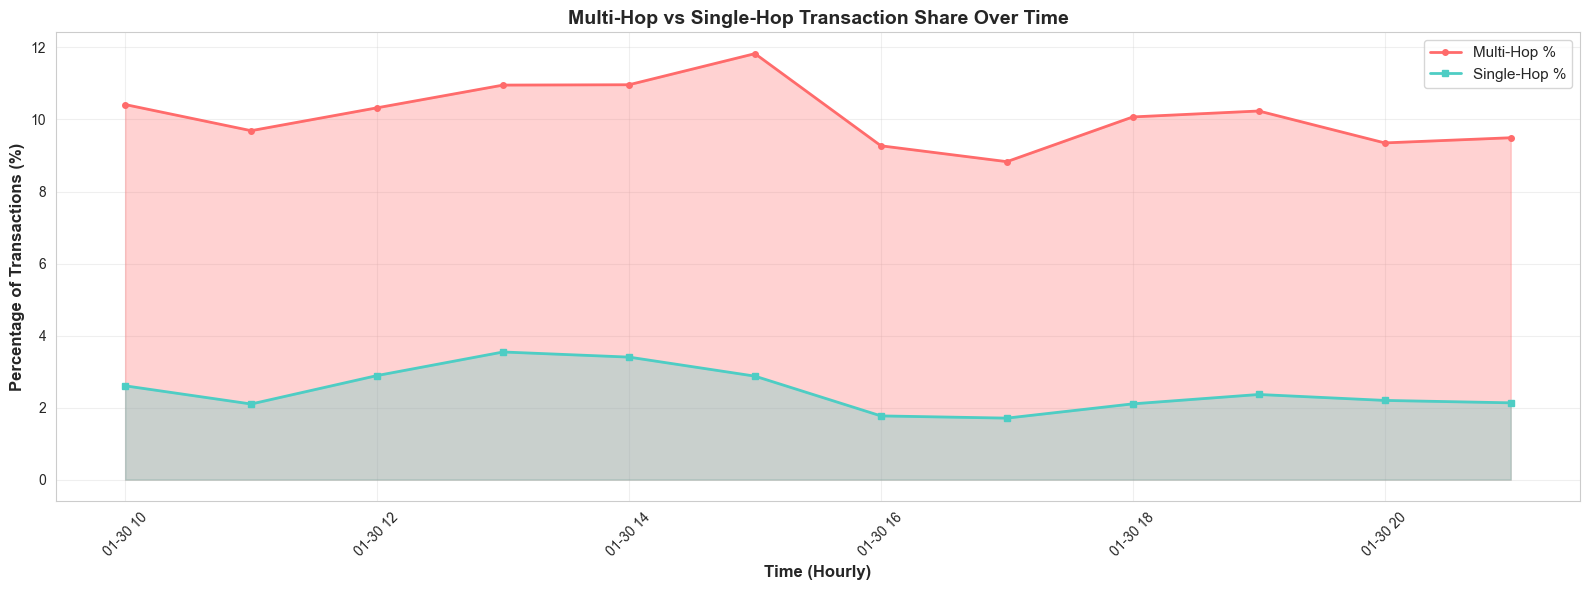

✓ Saved: 02_jupiter_timeseries_multihop.png


In [20]:
# ────────────────────────────────────────────────────────────
# Figure 2: Time-Series Multi-Hop Percentage
# ────────────────────────────────────────────────────────────

fig, ax = plt.subplots(figsize=(16, 6))

ax.plot(hourly_routing.index, hourly_routing['multihop_pct'], 
        label='Multi-Hop %', color='#FF6B6B', linewidth=2, marker='o', markersize=4)
ax.plot(hourly_routing.index, hourly_routing['singlehop_pct'], 
        label='Single-Hop %', color='#4ECDC4', linewidth=2, marker='s', markersize=4)

ax.fill_between(hourly_routing.index, hourly_routing['multihop_pct'], alpha=0.3, color='#FF6B6B')
ax.fill_between(hourly_routing.index, hourly_routing['singlehop_pct'], alpha=0.3, color='#4ECDC4')

ax.set_xlabel('Time (Hourly)', fontsize=12, fontweight='bold')
ax.set_ylabel('Percentage of Transactions (%)', fontsize=12, fontweight='bold')
ax.set_title('Multi-Hop vs Single-Hop Transaction Share Over Time', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3)
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('02_jupiter_timeseries_multihop.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: 02_jupiter_timeseries_multihop.png")

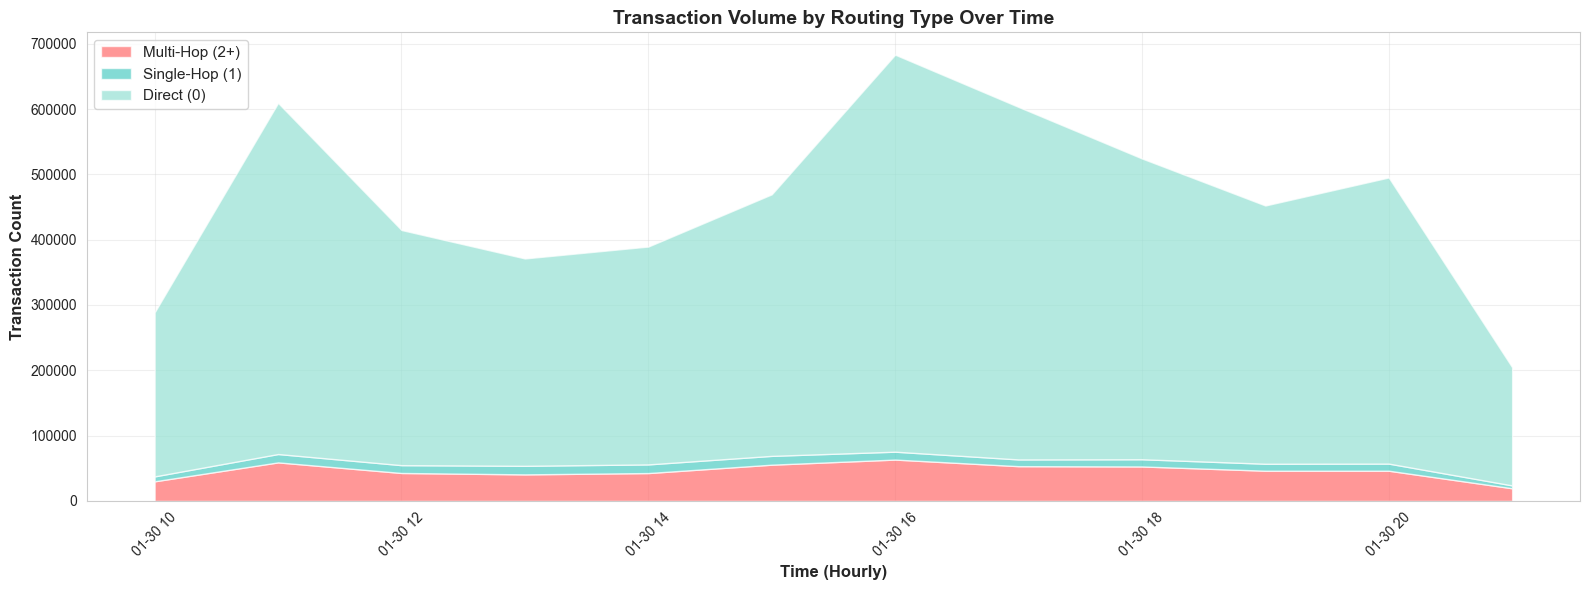

Saved: 02_jupiter_stacked_routing.png


In [23]:
# ────────────────────────────────────────────────────────────
# Figure 3: Stacked Area Chart (Hourly breakdown)
# ────────────────────────────────────────────────────────────

fig, ax = plt.subplots(figsize=(16, 6))

ax.stackplot(hourly_routing.index,
             hourly_routing['is_multihop'],
             hourly_routing['is_singlehop'],
             hourly_routing['is_direct'],
             labels=['Multi-Hop (2+)', 'Single-Hop (1)', 'Direct (0)'],
             colors=['#FF6B6B', '#4ECDC4', '#95E1D3'],
             alpha=0.7)

ax.set_xlabel('Time (Hourly)', fontsize=12, fontweight='bold')
ax.set_ylabel('Transaction Count', fontsize=12, fontweight='bold')
ax.set_title('Transaction Volume by Routing Type Over Time', fontsize=14, fontweight='bold')
ax.legend(loc='upper left', fontsize=11)
ax.grid(alpha=0.3)
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('02_jupiter_stacked_routing.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: 02_jupiter_stacked_routing.png")

## Step 8: Export Tagged Dataset

In [24]:
# ────────────────────────────────────────────────────────────
# Save the dataset with Jupiter tags for downstream analysis
# ────────────────────────────────────────────────────────────

output_dir = '01_data_cleaning/outputs'
os.makedirs(output_dir, exist_ok=True)

# Save full tagged dataset
tagged_path = os.path.join(output_dir, 'pamm_clean_with_jupiter_tags.parquet')
df.to_parquet(tagged_path, index=False)
print(f"✓ Saved full tagged dataset: {tagged_path}")

# Save summary statistics CSV
summary_stats = pd.DataFrame({
    'Metric': [
        'Total Transactions',
        'Multi-Hop (2+ hops)',
        'Single-Hop (1 hop)',
        'Direct (0 hops)',
        'Multi-Hop %',
        'Single-Hop %',
        'Direct %',
        'Unique Multi-Hop Routes',
        'Unique Single-Hop Routes',
        'Max Hop Count'
    ],
    'Value': [
        len(df),
        multihop_count,
        singlehop_count,
        direct_count,
        f"{multihop_pct:.2f}%",
        f"{singlehop_pct:.2f}%",
        f"{direct_pct:.2f}%",
        multihop_df['route_key'].nunique() if len(multihop_df) > 0 else 0,
        singlehop_df['route_key'].nunique() if len(singlehop_df) > 0 else 0,
        int(df['hop_count'].max())
    ]
})

summary_csv = os.path.join(output_dir, 'jupiter_routing_summary.csv')
summary_stats.to_csv(summary_csv, index=False)
print(f"✓ Saved summary stats: {summary_csv}")

print("\n" + "="*70)
print("ANALYSIS COMPLETE")
print("="*70)
print(f"\nAll columns available for further analysis:")
print(df.columns.tolist())
print(f"\nNew Jupiter-related columns:")
print([col for col in df.columns if 'hop' in col or 'route' in col or 'multihop' in col or 'singlehop' in col or 'direct' in col or 'routing' in col])

✓ Saved full tagged dataset: 01_data_cleaning/outputs/pamm_clean_with_jupiter_tags.parquet
✓ Saved summary stats: 01_data_cleaning/outputs/jupiter_routing_summary.csv

ANALYSIS COMPLETE

All columns available for further analysis:
['slot', 'time', 'validator', 'tx_idx', 'sig', 'signer', 'kind', 'amm_oracle', 'account_updates', 'trades', 'us_since_first_shred', 'amm_trade', 'account_trade', 'is_pool_trade', 'bytes_changed_trade', 'timing_missing', 'ms_time', 'datetime', 'hop_count', 'route_key', 'has_routing', 'is_multihop', 'is_singlehop', 'is_direct', 'hour']

New Jupiter-related columns:
['hop_count', 'route_key', 'has_routing', 'is_multihop', 'is_singlehop', 'is_direct']


## Pro Tips: Next Steps

### 🎯 Use these tags for:

1. **Contagion Analysis**: Filter to `is_multihop=True` to study "smart retail" that hits your pAMM as part of a 2+ hop route
   ```python
   df[df['is_multihop']].groupby('amm_trade')['sig'].count()
   ```

2. **Impact Analysis**: Compare slippage/fees between multi-hop vs single-hop routes hitting your Prop AMM
   ```python
   df.groupby('is_multihop')['bytes_changed_trade'].mean()
   ```

3. **MEV Detection**: Multi-hop routes often have higher MEV risk (searcher can split across multiple legs)
   ```python
   df[df['is_multihop'] & (df['kind'] == 'TRADE')]['signer'].nunique()
   ```

4. **Event Type Distribution**: Check if  multi-hop is ORACLE vs TRADE
   ```python
   df[df['is_multihop']]['kind'].value_counts()
   ```

### 📊 Visualizations saved:
- `02_jupiter_routing_distribution.png` - Overall split
- `02_jupiter_timeseries_multihop.png` - Multi-hop % over time
- `02_jupiter_stacked_routing.png` - Volume breakdown by hour

### 💾 Data exports:
- `pamm_clean_with_jupiter_tags.parquet` - Full dataset with new columns
- `jupiter_routing_summary.csv` - Summary statistics